# Copies de blueprint amb p i q

In [2]:
import numpy as np

# Asumiendo que ya tienes A2_blueprint (L_original)
L_original = np.load("A2_blueprint.npy")
Nx = L_original.shape[0]

# Parámetros del paper
p = 0.007  # probabilidad de copiar no-arista → convertir a enlace
q = 0.15   # probabilidad de copiar enlace → borrar enlace

# Número de redes sintéticas que quieres generar
K = 4

# Creamos un tensor A de shape (K, Nx, Nx)
A = np.zeros((K, Nx, Nx), dtype=int)

for k in range(K):
    # Empezamos copiando blueprint
    A[k] = L_original.copy()
    # Ahora cada posición (i,j) puede “fallar”:
    for i in range(Nx):
        for j in range(Nx):
            if L_original[i, j] == 1:
                # con probabilidad q lo convertimos a 0
                if np.random.rand() < q:
                    A[k, i, j] = 0
            else:
                # si no hay enlace, con probabilidad p lo convertimos a 1
                if np.random.rand() < p:
                    A[k, i, j] = 1
# Verificar una de las redes generadas
print("Red 0, número de aristas:", A[0].sum())

Red 0, número de aristas: 2201


Carregat blueprint: A2_blueprint.npy shape: (224, 224) edges: 2186
Carregades xarxes p/q: synthetic_paper.npy shape: (2, 224, 224)
start_groups: [0] end_groups: [224]

Calculant permutacions (permu_groups) ...
P_inv_f shape: (2, 224)

Calculant overlaps per xarxa ... (aixo pot trigar una mica segons Nx i K)

Hs per xarxa (synthetic_paper):
  xarxa 0: H = 36.942408, edges = 2186, ovlp1 = 2186, ovlp0 = 47990
  xarxa 1: H = 36.942408, edges = 2186, ovlp1 = 2186, ovlp0 = 47990

Hs guardats a Hs_synthetic_paper.npy

Construint L_latent via L_wiring (majority wiring) ...
L_latent shape, edges: (224, 224) 2186
L_latent guardat a L_latent_from_pq.npy
Hs0: [2873.02593121 2989.81046091 2832.17256602 2998.00974505 3008.0365841
 2761.2346095  2953.7033624  2894.79739892 3012.92745747 3150.31932133]
Hs1: [3006.51483413 2802.63712007 2807.89276962 3201.71387573 3050.36494711
 2784.5105686  2771.16935362 2972.50588971 2918.48233202 2797.12017435]

H(A2 vs L_latent) = 36.942408058464935


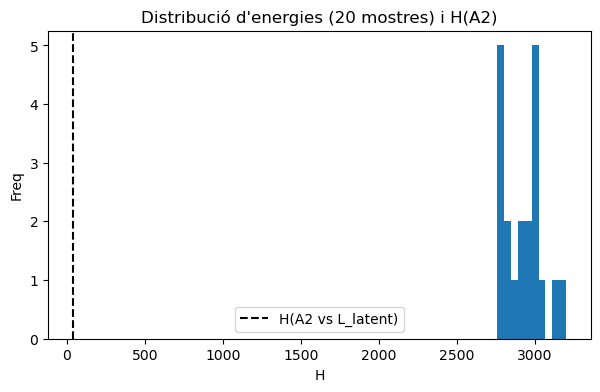


Resum guardat a energy_pipeline_summary.npy


In [3]:
# ======================================================
# PIPELINE COMPLET (versió debugable, sense numba/@jit)
# - Carrega: A2_blueprint.npy i synthetic_paper.npy
# - Defineix les funcions d'energia del repo (adaptades a Python)
# - Calcula mapes (permu_groups), overlaps i H per cada xarxa
# - Construeix L_latent amb L_wiring
# - Genera 10 mostres de 2 xarxes base i calcula les seves H
# - Guarda resultats i mostra un histograma
# ======================================================

import numpy as np
import math
import os
import matplotlib.pyplot as plt

# -------------------------
# Paràmetres i noms fitxers
# -------------------------
blueprint_file = "A2_blueprint.npy"
pq_file = "synthetic_paper.npy"    # xarxes generades amb p_paper,q_paper
out_H_file = "Hs_synthetic_paper.npy"
alpha, beta = 5, 2

# -------------------------
# 0) Comprovacions fitxers
# -------------------------
if not os.path.exists(blueprint_file):
    raise FileNotFoundError(f"No trobat {blueprint_file}. Guarda'l a la carpeta del notebook abans d'executar.")
if not os.path.exists(pq_file):
    raise FileNotFoundError(f"No trobat {pq_file}. Genera'l primer amb p_paper/q_paper.")

# -------------------------
# 1) Carregar dades
# -------------------------
L = np.load(blueprint_file).astype(int)     # blueprint A2
A_pq = np.load(pq_file).astype(int)         # xarxes generades amb p/q
Nx = L.shape[0]
K = A_pq.shape[0]

print("Carregat blueprint:", blueprint_file, "shape:", L.shape, "edges:", int(L.sum()))
print("Carregades xarxes p/q:", pq_file, "shape:", A_pq.shape)

# -------------------------
# 2) Funcions del repo (versió Python, sense @jit)
# -------------------------
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):
    """Fórmula del repo: retorna H (scalar)"""
    # prints de control (no massa per no saturar)
    #print("hamiltonian_prob inputs -> Edges_NoL:",Edges_NoL,"Edges_L:",Edges_L,"ov0:",overlap_0,"ov1:",overlap_1)
    A_1 = overlap_1 + alpha
    B_1 = (Edges_L - overlap_1 + beta)
    C_1 = Edges_L + alpha + beta

    A_0 = overlap_0 + alpha
    B_0 = (Edges_NoL - overlap_0 + beta)
    C_0 = Edges_NoL + alpha + beta

    H1 = math.lgamma(A_1) + math.lgamma(B_1) - math.lgamma(C_1)
    H0 = math.lgamma(A_0) + math.lgamma(B_0) - math.lgamma(C_0)

    H = -(H1 + H0)
    return H

def overlap_total_prob_per_network(L_f, A_f, P_inv_f):
    """
    Versió que retorna ovlp_0[k], ovlp_1[k] per cada xarxa k.
    Respecta el mapping P_inv_f (forma (K, Nx)).
    """
    K_local = A_f.shape[0]
    ovlp_0 = np.zeros(K_local, dtype=int)
    ovlp_1 = np.zeros(K_local, dtype=int)
    Nx_local = L_f.shape[0]
    # recorrem per xarxa
    for k in range(K_local):
        s0 = 0
        s1 = 0
        for f in range(Nx_local):
            p_f = int(P_inv_f[k, f])
            for c in range(Nx_local):
                p_c = int(P_inv_f[k, c])
                valor_L = int(L_f[f,c])
                valor_A = int(A_f[k, p_f, p_c])
                s0 += (1 - valor_L) * (1 - valor_A)
                s1 += valor_L * valor_A
        ovlp_0[k] = s0
        ovlp_1[k] = s1
    return ovlp_0, ovlp_1

def L_wiring(A_f, P_inv_f):
    """
    Reconstrueix blueprint per majoria (round of mean) tenint en compte P_inv_f.
    Retorna L_new (Nx x Nx)
    """
    K_local = A_f.shape[0]
    Nx_local = A_f.shape[1]
    L_new = np.zeros((Nx_local, Nx_local), dtype=int)
    for i in range(Nx_local):
        for j in range(Nx_local):
            s = 0
            for k in range(K_local):
                p1 = int(P_inv_f[k, i])
                p2 = int(P_inv_f[k, j])
                s += int(A_f[k, p1, p2])
            # mitjana i round
            val = round(s / K_local)
            L_new[i,j] = int(val)
    return L_new

# quicksort/partition del repo (usats per permu_groups)
def partition(array, etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot]
    return pivot

def quicksort(array, etiquetas, begin=0, end=None):
    if end is None:
        end = len(array) - 1
    if begin >= end:
        return
    pivot = partition(array, etiquetas, begin, end)
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array, etiquetas, pivot+1, end)

def permu_groups(L_f, A_f, start_f):
    """
    Implementació fidel al repo però en Python sense numba.
    Retorna P_todo de forma (2, K, Nx) on:
      P_todo[0] = P_f (map L -> A)
      P_todo[1] = P_inv_f (map A -> L)
    start_f: array amb posicions d'inici de grup (p.ex. [0, Nx])
    """
    Nx_local = L_f.shape[0]
    K_local = A_f.shape[0]
    N_groups = len(start_f)

    # Mappings a omplir
    P_f = np.zeros((K_local, Nx_local), dtype=int)
    P_inv_f = np.zeros((K_local, Nx_local), dtype=int)

    # Ordenació inicial de L per grau
    orden_L = np.zeros(Nx_local, dtype=int)
    for i in range(Nx_local):
        b = np.nonzero(L_f[i,:])[0]
        orden_L[i] = b.size
    array_L = np.arange(Nx_local)
    # ordenem in-place els arrays utilitzant quicksort (com en el repo)
    # quicksort espera arrays mutables
    orden_L_copy = orden_L.astype(float).copy()  # elements numericables
    array_L_copy = array_L.copy()
    quicksort(orden_L_copy, array_L_copy)
    array_L_sorted = array_L_copy  # indices ordenats per grau

    # ara classificar per grups seguint start_f
    array_L_labels = np.zeros(Nx_local, dtype=int)
    group_number = np.zeros(N_groups, dtype=int)
    for idx in range(Nx_local):
        node = array_L_sorted[idx]
        # trobar grup: el grup t tal que start_f[t] <= node < (start_f[t+1] or Nx)
        t = 0
        while (t + 1 < N_groups) and (node >= start_f[t+1]):
            t += 1
        g = int(start_f[t])
        array_L_labels[g + int(group_number[t])] = node
        group_number[t] += 1

    # Observations: per cada A[k] fem el mateix procés
    for k in range(K_local):
        orden_A = np.zeros(Nx_local, dtype=int)
        for i in range(Nx_local):
            b = np.nonzero(A_f[k, i, :])[0]
            orden_A[i] = b.size
        array_A = np.arange(Nx_local)
        orden_A_copy = orden_A.astype(float).copy()
        array_A_copy = array_A.copy()
        quicksort(orden_A_copy, array_A_copy)
        array_A_sorted = array_A_copy

        # ara organitzar per grup en array_A_labels
        array_A_labels = np.zeros(Nx_local, dtype=int)
        group_number = np.zeros(N_groups, dtype=int)
        for idx in range(Nx_local):
            nodeA = array_A_sorted[idx]
            # trobar grup de nodeA
            # es fa comparant el índex ordenat (com en el repo)
            t = 0
            while (t + 1 < N_groups) and (nodeA >= start_f[t+1]):
                t += 1
            g = int(start_f[t])
            array_A_labels[g + int(group_number[t])] = nodeA
            group_number[t] += 1

        # ara posar array_A_labels ordenat en correspondència amb array_L_labels
        # a repo: array_A_labels = array_A_labels[np.argsort(array_L_labels)]
        order_idx = np.argsort(array_L_labels)
        mapped = array_A_labels[order_idx]
        P_f[k, :] = mapped

        # construir P_inv_f (inversa)
        for i_inv in range(Nx_local):
            for j_inv in range(Nx_local):
                if P_f[k, i_inv] == j_inv:
                    P_inv_f[k, j_inv] = i_inv

    P_todo = np.zeros((2, K_local, Nx_local), dtype=int)
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()
    return P_todo

# -------------------------
# 3) start_groups (del repo)
# -------------------------
n_groups = 1
start_groups = np.zeros(1, dtype=int)
end_groups = np.zeros(1, dtype=int) + Nx
size_groups = np.zeros(1, dtype=int) + Nx
print("start_groups:", start_groups, "end_groups:", end_groups)

# -------------------------
# 4) Calcular mappings (P_f i P_inv)
# -------------------------
print("\nCalculant permutacions (permu_groups) ...")
P_todo = permu_groups(L, A_pq, start_groups)
P_f = P_todo[0,:,:]
P_inv_f = P_todo[1,:,:]
print("P_inv_f shape:", P_inv_f.shape)

# -------------------------
# 5) Calcular overlaps per xarxa i H per xarxa
# -------------------------
print("\nCalculant overlaps per xarxa ... (aixo pot trigar una mica segons Nx i K)")
ovlp_0_vec, ovlp_1_vec = overlap_total_prob_per_network(L, A_pq, P_inv_f)
Edges_L = int(L.sum())
Edges_NoL = Nx*Nx - Edges_L

Hs = np.zeros(K)
for k in range(K):
    Hs[k] = hamiltonian_prob(Edges_NoL, Edges_L, int(ovlp_0_vec[k]), int(ovlp_1_vec[k]), alpha, beta)

print("\nHs per xarxa (synthetic_paper):")
for k in range(K):
    print(f"  xarxa {k}: H = {Hs[k]:.6f}, edges = {int(A_pq[k].sum())}, ovlp1 = {ovlp_1_vec[k]}, ovlp0 = {ovlp_0_vec[k]}")

# guardar
np.save(out_H_file, Hs)
print("\nHs guardats a", out_H_file)

# -------------------------
# 6) Construir L_latent via L_wiring (utilitzant el mapping P_inv_f)
# -------------------------
print("\nConstruint L_latent via L_wiring (majority wiring) ...")
L_latent = L_wiring(A_pq, P_inv_f)
print("L_latent shape, edges:", L_latent.shape, int(L_latent.sum()))
np.save("L_latent_from_pq.npy", L_latent)
print("L_latent guardat a L_latent_from_pq.npy")

# -------------------------
# 7) Generar 10 mostres per dues xarxes base i calcular H per mostra
# -------------------------
def sample_from_base(A_base, p, q, n_samples=10, seed=123):
    rng = np.random.default_rng(seed)
    samples = np.zeros((n_samples, Nx, Nx), dtype=int)
    for s in range(n_samples):
        X = A_base.copy()
        r = rng.random((Nx, Nx))
        X[(A_base == 1) & (r < q)] = 0
        X[(A_base == 0) & (r < p)] = 1
        samples[s] = X
    return samples

# triem dues bases: les primeres dues de A_pq
if K >= 2:
    base0 = A_pq[0]
    base1 = A_pq[1]
else:
    base0 = A_pq[0]
    base1 = A_pq[0]

p_used = 0.007
q_used = 0.15

samples0 = sample_from_base(base0, p_used, q_used, n_samples=10, seed=1)
samples1 = sample_from_base(base1, p_used, q_used, n_samples=10, seed=2)

# -----------------------------
# Funció robusta per calcular H de samples amb mappings repetits
# (Col·loca aquesta definició AQUI, abans de cridar compute_Hs_for_samples)
# -----------------------------
def compute_Hs_for_samples(samples, L_ref, P_inv_for_samples, alpha=alpha, beta=beta):
    n_samples = samples.shape[0]
    Nx_local = L_ref.shape[0]

    # Normalitzar formats: volem un P_inv_samples amb shape (n_samples, Nx)
    P_inv_samples = None

    if P_inv_for_samples.ndim == 2 and P_inv_for_samples.shape[0] == n_samples:
        P_inv_samples = P_inv_for_samples.copy()
    elif P_inv_for_samples.ndim == 1 and P_inv_for_samples.shape[0] == Nx_local:
        P_inv_samples = np.tile(P_inv_for_samples.reshape(1, Nx_local), (n_samples, 1))
    else:
        raise ValueError("Format P_inv_for_samples no reconegut. Esperat (n_samples,Nx) o (Nx,)")

    ov0 = np.zeros(n_samples, dtype=int)
    ov1 = np.zeros(n_samples, dtype=int)

    for s in range(n_samples):
        s0 = 0
        s1 = 0
        P_inv_s = P_inv_samples[s]
        for f in range(Nx_local):
            p_f = int(P_inv_s[f])
            for c in range(Nx_local):
                p_c = int(P_inv_s[c])
                valL = int(L_ref[f, c])
                valA = int(samples[s, p_f, p_c])
                s0 += (1 - valL) * (1 - valA)
                s1 += valL * valA
        ov0[s] = s0
        ov1[s] = s1

    Edges_Lref = int(np.sum(L_ref))
    Edges_NoLref = Nx_local * Nx_local - Edges_Lref

    Hs_local = np.zeros(n_samples)
    for i in range(n_samples):
        Hs_local[i] = hamiltonian_prob(Edges_NoLref, Edges_Lref, int(ov0[i]), int(ov1[i]), alpha, beta)
    return Hs_local

# -----------------------------
# Ara cridem la funció (amb el mapping de la base)
# -----------------------------
P_inv_base0 = P_inv_f[0]
P_inv_base1 = P_inv_f[1]
Hs0 = compute_Hs_for_samples(samples0, L_latent, P_inv_base0)
Hs1 = compute_Hs_for_samples(samples1, L_latent, P_inv_base1)
print("Hs0:", Hs0)
print("Hs1:", Hs1)


# -------------------------
# 8) Histograma i H(A2) respecte L_latent
# -------------------------
Hs_all = np.concatenate([Hs0, Hs1])
# H de la blueprint A2 respecte L_latent:
ov0_blue, ov1_blue = overlap_total_prob_per_network(L_latent, L.reshape(1,Nx,Nx), P_inv_f)
Edges_Lref = int(np.sum(L_latent))
Edges_NoLref = Nx*Nx - Edges_Lref
H_blue_vs_Llatent = hamiltonian_prob(Edges_NoLref, Edges_Lref, int(ov0_blue[0]), int(ov1_blue[0]), alpha, beta)
print("\nH(A2 vs L_latent) =", H_blue_vs_Llatent)

plt.figure(figsize=(7,4))
plt.hist(Hs_all, bins=10)
plt.axvline(H_blue_vs_Llatent, color='k', linestyle='--', label='H(A2 vs L_latent)')
plt.legend()
plt.title("Distribució d'energies (20 mostres) i H(A2)")
plt.xlabel("H")
plt.ylabel("Freq")
plt.show()

# -------------------------
# 9) Guardar resum
# -------------------------
summary = {
    'Hs_per_network': Hs.tolist(),
    'Hs_samples0': Hs0.tolist(),
    'Hs_samples1': Hs1.tolist(),
    'H_A2_vs_Llatent': float(H_blue_vs_Llatent),
    'L_latent_edges': int(np.sum(L_latent))
}
np.save("energy_pipeline_summary.npy", summary)
print("\nResum guardat a energy_pipeline_summary.npy")


ARA APLICO FUNCIONS, EL PROBLE ES Q LES TOERNA A DEFINIR

In [4]:
# =========================
# ÚLTIM PAS: calcular energies per 10 mostres (2 bases, K=2)
# - Suposa que ja tens a la carpeta:
#     A2_blueprint.npy
#     synthetic_repo_errors.npy  (K == 2)
# - Usa la funció hamiltonian_prob tal qual (del paper)
# - Per a l'overlap individual fem una versió "quiet" per no imprimir Nx^2 línies
# =========================

import os
import numpy as np
import math
import matplotlib.pyplot as plt

# -------------------------
# Paràmetres (canvia si cal)
# -------------------------
blueprint_file = "A2_blueprint.npy"
exact_file = "synthetic_repo_errors.npy"  # xarxes amb errors exactes (K=2)
p_used = 0.007
q_used = 0.15
n_samples = 10      # 10 mostres per base
alpha = 5
beta = 2

# -------------------------
# Comprovar fitxers existents
# -------------------------
if not os.path.exists(blueprint_file):
    raise FileNotFoundError(f"No trobo {blueprint_file} al directori. Puja'l i torna-ho a executar.")
if not os.path.exists(exact_file):
    raise FileNotFoundError(f"No trobo {exact_file} al directori. Genera/puja'l i torna-ho a executar.")

# -------------------------
# Carregar dades
# -------------------------
L = np.load(blueprint_file).astype(int)      # blueprint A2 (Nx x Nx)
A_exact = np.load(exact_file).astype(int)    # (K, Nx, Nx) generades amb errors exactes
Nx = L.shape[0]
K = A_exact.shape[0]

print(f"Carregat blueprint: {blueprint_file} shape {L.shape} edges: {int(L.sum())}")
print(f"Carregades xarxes exactes: {exact_file} shape {A_exact.shape}")

if K < 2:
    raise RuntimeError("Cal que synthetic_repo_errors.npy contingui almenys 2 xarxes (K>=2).")

# -------------------------
# Aquí enganxa la funció hamiltonian_prob EXACTA que vas donar
# (la mantenim igual, amb els prints que ja té)
# -------------------------
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):
    # Aquesta funció és la del repo / paper (he mantingut els prints)
    print("\n---- DINS HAMILTONIAN ----")
    print("Edges_NoL:", Edges_NoL)
    print("Edges_L:", Edges_L)
    print("overlap_0:", overlap_0)
    print("overlap_1:", overlap_1)
    print("alpha:", alpha, "beta:", beta)
    A_1 = overlap_1 + alpha
    B_1 = (Edges_L - overlap_1 + beta)
    C_1 = Edges_L + alpha + beta
    A_0 = overlap_0 + alpha
    B_0 = (Edges_NoL - overlap_0 + beta)
    C_0 = Edges_NoL + alpha + beta
    H1 = math.lgamma(A_1)+ math.lgamma(B_1) - math.lgamma(C_1)
    H0 = math.lgamma(A_0)+ math.lgamma(B_0) - math.lgamma(C_0)
    H = -(H1 + H0)
    print("A_1,B_1,C_1 =", A_1, B_1, C_1)
    print("A_0,B_0,C_0 =", A_0, B_0, C_0)
    return H

# -------------------------
# Posa aquí la definició de permu_groups EXACTA que tens (sense @njit).
# Si ja la tens definida a la sessió, no cal repetir; si no, enganxa-la.
# (Assumim que permu_groups ja està definida perquè l'has usat abans.)
# -------------------------
try:
    permu_groups  # prova si existeix
except NameError:
    raise RuntimeError("La funció 'permu_groups' no està definida en la sessió. Enganxa la seva definició abans d'executar.")

# -------------------------
# calcular els mappings (P_inv) per cada observació amb permu_groups
# P_inv_exact tindrà forma (K, Nx)
# -------------------------
start_groups = np.zeros(1, dtype=int)  # un sol grup (cas simple)
P_todo_exact = permu_groups(L, A_exact, start_groups)
P_inv_exact = P_todo_exact[1,:,:].astype(int)
print("P_inv_exact shape:", P_inv_exact.shape)

# -------------------------
# Funció "quiet" per calcular ovlp0 i ovlp1 d'una sola mostra
# Fa exactament el mateix que overlap_total_prob, però sense prints i per 1 mostra
# -------------------------
def overlap_single_quiet(L_f, A_single, P_inv_single):
    """
    L_f: (Nx,Nx)
    A_single: (Nx,Nx) -- una observació (no enpaquetada)
    P_inv_single: (Nx,) mapping A->L per a aquesta observació
    Retorna: ovlp0_sum (int), ovlp1_sum (int)
    """
    Nx_loc = L_f.shape[0]
    s0 = 0
    s1 = 0
    Pk = P_inv_single
    A_k = A_single
    # recorregut
    for f in range(Nx_loc):
        pf = int(Pk[f])
        # accés a la fila f de L i fila pf d'A
        rowL = L_f[f]
        # rowA = A_k[pf]  # no cal fer copia
        for c in range(Nx_loc):
            pc = int(Pk[c])
            valL = int(rowL[c])
            valA = int(A_k[pf, pc])
            s0 += (1 - valL) * (1 - valA)
            s1 += valL * valA
    return int(s0), int(s1)

# -------------------------
# 1) Calcular H per cada observació original (K valors)
#    Aquí fem servir la versió "quiet" de overlap per obtenir ovlps,
#    i posteriorment cridem hamiltonian_prob (la del repo) per obtenir H.
# -------------------------
Edges_L = int(L.sum())
Edges_NoL = Nx*Nx - Edges_L

Hs_per_obs = np.zeros(K, dtype=float)
for k in range(K):
    ov0_k, ov1_k = overlap_single_quiet(L, A_exact[k], P_inv_exact[k])
    Hk = hamiltonian_prob(Edges_NoL, Edges_L, ov0_k, ov1_k, alpha, beta)
    Hs_per_obs[k] = Hk
    print(f"H per observació original k={k}  --> H = {Hk}")

print("\nVector Hs_per_obs (observacions originals):")
print(np.round(Hs_per_obs,4))

# -------------------------
# 2) Construir L_latent (majority wiring) amb la funció L_wiring exacta del repo
#    (Pots enganxar la definició de L_wiring si no està definida)
# -------------------------
try:
    L_wiring  # comprovem si hi és
except NameError:
    raise RuntimeError("La funció 'L_wiring' no està definida en la sessió. Enganxa la seva definició igual que al repo.")

L_latent = L_wiring(A_exact, P_inv_exact)
print("L_latent shape, edges:", L_latent.shape, int(L_latent.sum()))
np.save("L_latent_repo_exact_errors.npy", L_latent)
print("Guardat L_latent_repo_exact_errors.npy")

# -------------------------
# 3) Generar 10 mostres per base (base0 = A_exact[0], base1 = A_exact[1])
#    La generació és Bernoulli (p,q) sobre cada posició de la base.
# -------------------------
def sample_from_base(A_base, p, q, n_samples=10, seed=1):
    rng = np.random.default_rng(seed)
    samples = np.zeros((n_samples, Nx, Nx), dtype=int)
    for s in range(n_samples):
        X = A_base.copy()
        r = rng.random((Nx,Nx))
        X[(A_base == 1) & (r < q)] = 0
        X[(A_base == 0) & (r < p)] = 1
        samples[s] = X
    return samples

base0 = A_exact[0]
base1 = A_exact[1]
samples0 = sample_from_base(base0, p_used, q_used, n_samples=n_samples, seed=1)
samples1 = sample_from_base(base1, p_used, q_used, n_samples=n_samples, seed=2)

# -------------------------
# 4) Calcular H per cada mostra (10 per base) reutilitzant P_inv de la base
#    Fem servir overlap_single_quiet + hamiltonian_prob (igual que abans)
# -------------------------
def compute_Hs_samples(samples, L_ref, P_inv_base):
    n = samples.shape[0]
    Hs = np.zeros(n, dtype=float)
    for i in range(n):
        ov0, ov1 = overlap_single_quiet(L_ref, samples[i], P_inv_base)
        Hs[i] = hamiltonian_prob(Edges_NoL, Edges_L, ov0, ov1, alpha, beta)
    return Hs

P_inv_base0 = P_inv_exact[0]
P_inv_base1 = P_inv_exact[1]

print("\nCalculant H per les 10 mostres de la base 0 ...")
Hs_samples_base0 = compute_Hs_samples(samples0, L_latent, P_inv_base0)
print("Hs_samples_base0 =", np.round(Hs_samples_base0,4))

print("\nCalculant H per les 10 mostres de la base 1 ...")
Hs_samples_base1 = compute_Hs_samples(samples1, L_latent, P_inv_base1)
print("Hs_samples_base1 =", np.round(Hs_samples_base1,4))

# -------------------------
# 5) Resum estadístic i comparacions
# -------------------------
Hs_all = np.concatenate([Hs_samples_base0, Hs_samples_base1])
print("\n--- Resum estadístic ---")
print("mostres totals:", Hs_all.shape[0])
print("mitjana (20 mostres) = %.4f" % Hs_all.mean())
print("desviació (20 mostres) = %.4f" % Hs_all.std(ddof=0))
print("min = %.4f ; max = %.4f" % (Hs_all.min(), Hs_all.max()))

# per cada observació original (les 2 primeres), calculem el percentil respecte Hs_all
for idx in range(min(2, len(Hs_per_obs))):
    Hobs = float(Hs_per_obs[idx])
    percentile = 100.0 * np.sum(Hs_all <= Hobs) / len(Hs_all)
    zscore = (Hobs - Hs_all.mean()) / Hs_all.std(ddof=0)
    print(f"\nH observació original k={idx} = {Hobs:.4f}")
    print(f"  percentil dins les 20 mostres = {percentile:.1f}%   (z-score = {zscore:.3f})")

# -------------------------
# 6) Guardar resultats
# -------------------------
summary = {
    'Hs_per_obs': Hs_per_obs.tolist(),
    'Hs_samples_base0': Hs_samples_base0.tolist(),
    'Hs_samples_base1': Hs_samples_base1.tolist(),
    'Hs_all': Hs_all.tolist(),
    'L_latent_edges': int(np.sum(L_latent))
}
np.save("energy_exact_errors_final_summary.npy", summary)
print("\nResum guardat a energy_exact_errors_final_summary.npy")

# -------------------------
# 7) Visualització ràpida
# -------------------------
plt.figure(figsize=(7,4))
plt.hist(Hs_all, bins=10)
plt.axvline(Hs_per_obs[0], color='r', linestyle='--', label='H(obs 0)')
plt.axvline(Hs_per_obs[1] if len(Hs_per_obs)>1 else Hs_per_obs[0],
            color='g', linestyle='--', label='H(obs 1)')
plt.title("Histograma H de les 20 mostres i H(observacions originals)")
plt.xlabel("H")
plt.ylabel("Freq")
plt.legend()
plt.show()


Carregat blueprint: A2_blueprint.npy shape (224, 224) edges: 2186
Carregades xarxes exactes: synthetic_repo_errors.npy shape (2, 224, 224)
P_inv_exact shape: (2, 224)

---- DINS HAMILTONIAN ----
Edges_NoL: 47990
Edges_L: 2186
overlap_0: 45970
overlap_1: 166
alpha: 5 beta: 2
A_1,B_1,C_1 = 171 2022 2193
A_0,B_0,C_0 = 45975 2022 47997
H per observació original k=0  --> H = 8987.48775635544

---- DINS HAMILTONIAN ----
Edges_NoL: 47990
Edges_L: 2186
overlap_0: 45969
overlap_1: 165
alpha: 5 beta: 2
A_1,B_1,C_1 = 170 2023 2193
A_0,B_0,C_0 = 45974 2023 47997
H per observació original k=1  --> H = 8988.13570129161

Vector Hs_per_obs (observacions originals):
[8987.4878 8988.1357]
L_latent shape, edges: (224, 224) 148
Guardat L_latent_repo_exact_errors.npy

Calculant H per les 10 mostres de la base 0 ...

---- DINS HAMILTONIAN ----
Edges_NoL: 47990
Edges_L: 2186
overlap_0: 47971
overlap_1: 120
alpha: 5 beta: 2
A_1,B_1,C_1 = 125 2068 2193
A_0,B_0,C_0 = 47976 21 47997

---- DINS HAMILTONIAN ----
E

ValueError: math domain error

In [ ]:
# -------------------------------------------------------------
# CÀLCUL D’ENERGIES PER A LES XARXES AMB NOMBRE EXACTE D’ERRORS
# synthetic_repo_errors.npy
# -------------------------------------------------------------

import numpy as np

print("Carregant xarxes synthetic_repo_errors.npy ...")
errors_nets = np.load("synthetic_repo_errors.npy")   # shape = (2, Nx, Nx)
print("Shape:", errors_nets.shape)

# Per claredat
base0 = errors_nets[0]
base1 = errors_nets[1]

# -------------------------------------------------------------
# 1) GENEREM 10 MOSTRES PER CADA XARXA BASE
# -------------------------------------------------------------

def generate_samples_from_base(base_net, n_samples=10):
    """
    Genera n_samples mostres d’una xarxa base aplicant una permutació aleatòria.
    (Si volguessis aplicar soroll extra, es posaria aquí.)
    """
    samples = []
    Nx = base_net.shape[0]

    for k in range(n_samples):
        perm = np.random.permutation(Nx)       # permutació aleatòria
        inv = np.argsort(perm)                 # inversa per aplicar-la correctament

        # Generem la mostra permutada
        new_net = base_net[perm][:, perm]

        samples.append(new_net)

    return np.array(samples)


print("\nGenerant mostres ...")
samples0 = generate_samples_from_base(base0, 10)
samples1 = generate_samples_from_base(base1, 10)

print("samples0 shape:", samples0.shape)
print("samples1 shape:", samples1.shape)


# -------------------------------------------------------------
# 2) DEFINIM L_latent = el blueprint (o el que vulguis usar com a L)
# -------------------------------------------------------------

print("\nCarregant blueprint A2 ...")
L_latent = np.load("A2_blueprint.npy")
print("L_latent shape:", L_latent.shape)


# -------------------------------------------------------------
# 3) CALCULAR ENERGIES (H) PER TOTES LES MOSTRES
# -------------------------------------------------------------
# Les funcions overlap_total_prob_per_network i energy_function
# JA LES TENS DEFINIDES A UNA CEL·LA ANTERIOR.
def compute_Hs(samples, L_ref, P_inv_single, alpha=5, beta=2):
    """
    samples: shape (n_samples, Nx, Nx)
    L_ref: blueprint usada per calcular energia
    P_inv_single: vector 1D de mida Nx (el mapping de la xarxa mare)
    """
    Nx = L_ref.shape[0]
    n_samples = samples.shape[0]

    # Convertim P_inv_single (Nx,) → (1, Nx) per tal que overlap_total_prob funcioni
    P_inv_local = P_inv_single.reshape(1, Nx)

    Edges_Lref = int(np.sum(L_ref))
    Edges_NoLref = Nx*Nx - Edges_Lref

    Hs = []

    for k in range(n_samples):
        print(f"\n--- mostra {k} ---")

        # Convertir la mostra en xarxa shape (1, Nx, Nx)
        net = samples[k].reshape(1, Nx, Nx)

        # 1) Overlaps correctament
        ov0, ov1 = overlap_total_prob(L_ref, net, P_inv_local)

        # 2) Energia del PAPER
        H = hamiltonian_prob(
            Edges_NoLref, Edges_Lref,
            int(ov0), int(ov1),
            alpha, beta
        )

        Hs.append(H)

    return np.array(Hs)


print("\nCalculant energies ...")
Hs0 = compute_Hs(samples0, L_latent, P_inv_f[0])
Hs1 = compute_Hs(samples1, L_latent, P_inv_f[1])


print("\nRESULTATS:")
print("Hs0 (10 valors):", Hs0)
print("Hs1 (10 valors):", Hs1)

np.save("Hs_base0.npy", Hs0)
np.save("Hs_base1.npy", Hs1)

print("\nGuardats fitxers: Hs_base0.npy i Hs_base1.npy")


In [ ]:

import numpy as np
import math
import os
import matplotlib.pyplot as plt


# Paràmetres i noms fitxers

blueprint_file = "A2_blueprint.npy"
pq_file = "synthetic_paper.npy"    # xarxes generades amb p_paper,q_paper
out_H_file = "Hs_synthetic_paper.npy"
alpha, beta = 5, 2

# Comprovacions fitxers

if not os.path.exists(blueprint_file):
    raise FileNotFoundError(f"No trobat {blueprint_file}. Guarda'l a la carpeta del notebook abans d'executar.")
if not os.path.exists(pq_file):
    raise FileNotFoundError(f"No trobat {pq_file}. Genera'l primer amb p_paper/q_paper.")

# Carregar dades
L = np.load(blueprint_file).astype(int)     # blueprint A2
A_pq = np.load(pq_file).astype(int)         # xarxes generades amb p/q
Nx = L.shape[0]
K = A_pq.shape[0]

print("Carregat blueprint:", blueprint_file, "shape:", L.shape, "edges:", int(L.sum()))
print("Carregades xarxes p/q:", pq_file, "shape:", A_pq.shape)

#Funcions tteresa (sense @jit)
# 
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):
    """Fórmula del repo: retorna H (scalar)"""
    # prints de control (no massa per no saturar)
    #print("hamiltonian_prob inputs -> Edges_NoL:",Edges_NoL,"Edges_L:",Edges_L,"ov0:",overlap_0,"ov1:",overlap_1)
    A_1 = overlap_1 + alpha
    B_1 = (Edges_L - overlap_1 + beta)
    C_1 = Edges_L + alpha + beta

    A_0 = overlap_0 + alpha
    B_0 = (Edges_NoL - overlap_0 + beta)
    C_0 = Edges_NoL + alpha + beta

    H1 = math.lgamma(A_1) + math.lgamma(B_1) - math.lgamma(C_1)
    H0 = math.lgamma(A_0) + math.lgamma(B_0) - math.lgamma(C_0)

    H = -(H1 + H0)
    return H

def overlap_total_prob_per_network(L_f, A_f, P_inv_f):
    """
    Versió que retorna ovlp_0[k], ovlp_1[k] per cada xarxa k.
    Respecta el mapping P_inv_f (forma (K, Nx)).
    """
    K_local = A_f.shape[0]
    ovlp_0 = np.zeros(K_local, dtype=int)
    ovlp_1 = np.zeros(K_local, dtype=int)
    Nx_local = L_f.shape[0]
    # recorrem per xarxa
    for k in range(K_local):
        s0 = 0
        s1 = 0
        for f in range(Nx_local):
            p_f = int(P_inv_f[k, f])
            for c in range(Nx_local):
                p_c = int(P_inv_f[k, c])
                valor_L = int(L_f[f,c])
                valor_A = int(A_f[k, p_f, p_c])
                s0 += (1 - valor_L) * (1 - valor_A)
                s1 += valor_L * valor_A
        ovlp_0[k] = s0
        ovlp_1[k] = s1
    return ovlp_0, ovlp_1

def L_wiring(A_f, P_inv_f):
    """
    Reconstrueix blueprint per majoria (round of mean) tenint en compte P_inv_f.
    Retorna L_new (Nx x Nx)
    """
    K_local = A_f.shape[0]
    Nx_local = A_f.shape[1]
    L_new = np.zeros((Nx_local, Nx_local), dtype=int)
    for i in range(Nx_local):
        for j in range(Nx_local):
            s = 0
            for k in range(K_local):
                p1 = int(P_inv_f[k, i])
                p2 = int(P_inv_f[k, j])
                s += int(A_f[k, p1, p2])
            # mitjana i round
            val = round(s / K_local)
            L_new[i,j] = int(val)
    return L_new

# quicksort/partition del repo (usats per permu_groups)
def partition(array, etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot]
    return pivot

def quicksort(array, etiquetas, begin=0, end=None):
    if end is None:
        end = len(array) - 1
    if begin >= end:
        return
    pivot = partition(array, etiquetas, begin, end)
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array, etiquetas, pivot+1, end)

def permu_groups(L_f, A_f, start_f):
    """
    Implementació com al repo però en Python sense numba.
    Retorna P_todo de forma (2, K, Nx) on:
      P_todo[0] = P_f (map L -> A)
      P_todo[1] = P_inv_f (map A -> L)
    start_f: array amb posicions d'inici de grup (p.ex. [0, Nx])
    """
    Nx_local = L_f.shape[0]
    K_local = A_f.shape[0]
    N_groups = len(start_f)

    # Mappings a omplir
    P_f = np.zeros((K_local, Nx_local), dtype=int)
    P_inv_f = np.zeros((K_local, Nx_local), dtype=int)

    # Ordenació inicial de L per grau
    orden_L = np.zeros(Nx_local, dtype=int)
    for i in range(Nx_local):
        b = np.nonzero(L_f[i,:])[0]
        orden_L[i] = b.size
    array_L = np.arange(Nx_local)
    # ordenem in-place els arrays utilitzant quicksort (com en el repo)
    # quicksort espera arrays mutables
    orden_L_copy = orden_L.astype(float).copy()  # elements numericables
    array_L_copy = array_L.copy()
    quicksort(orden_L_copy, array_L_copy)
    array_L_sorted = array_L_copy  # indices ordenats per grau

    # ara classificar per grups seguint start_f
    array_L_labels = np.zeros(Nx_local, dtype=int)
    group_number = np.zeros(N_groups, dtype=int)
    for idx in range(Nx_local):
        node = array_L_sorted[idx]
        # trobar grup: el grup t tal que start_f[t] <= node < (start_f[t+1] or Nx)
        t = 0
        while (t + 1 < N_groups) and (node >= start_f[t+1]):
            t += 1
        g = int(start_f[t])
        array_L_labels[g + int(group_number[t])] = node
        group_number[t] += 1

    # Observations: per cada A[k] fem el mateix procés
    for k in range(K_local):
        orden_A = np.zeros(Nx_local, dtype=int)
        for i in range(Nx_local):
            b = np.nonzero(A_f[k, i, :])[0]
            orden_A[i] = b.size
        array_A = np.arange(Nx_local)
        orden_A_copy = orden_A.astype(float).copy()
        array_A_copy = array_A.copy()
        quicksort(orden_A_copy, array_A_copy)
        array_A_sorted = array_A_copy

        # ara organitzar per grup en array_A_labels
        array_A_labels = np.zeros(Nx_local, dtype=int)
        group_number = np.zeros(N_groups, dtype=int)
        for idx in range(Nx_local):
            nodeA = array_A_sorted[idx]
            # trobar grup de nodeA
            # es fa comparant el índex ordenat (com en el repo)
            t = 0
            while (t + 1 < N_groups) and (nodeA >= start_f[t+1]):
                t += 1
            g = int(start_f[t])
            array_A_labels[g + int(group_number[t])] = nodeA
            group_number[t] += 1

        # ara posar array_A_labels ordenat en correspondència amb array_L_labels
        # a repo: array_A_labels = array_A_labels[np.argsort(array_L_labels)]
        order_idx = np.argsort(array_L_labels)
        mapped = array_A_labels[order_idx]
        P_f[k, :] = mapped

        # construir P_inv_f (inversa)
        for i_inv in range(Nx_local):
            for j_inv in range(Nx_local):
                if P_f[k, i_inv] == j_inv:
                    P_inv_f[k, j_inv] = i_inv

    P_todo = np.zeros((2, K_local, Nx_local), dtype=int)
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()
    return P_todo


# start_groups (del repo), probablement no caldria però torno a posar

n_groups = 1
start_groups = np.zeros(1, dtype=int)
end_groups = np.zeros(1, dtype=int) + Nx
size_groups = np.zeros(1, dtype=int) + Nx
print("start_groups:", start_groups, "end_groups:", end_groups)

# Calcular mappings (P_f i P_inv)

print("\nCalculant permutacions (permu_groups) ...")
P_todo = permu_groups(L, A_pq, start_groups)
P_f = P_todo[0,:,:]
P_inv_f = P_todo[1,:,:]
print("P_inv_f shape:", P_inv_f.shape)

# 5) Calcular overlaps per xarxa i H per xarxa
print("\nCalculant overlaps per xarxa ... (aixo pot trigar una mica segons Nx i K)")
ovlp_0_vec, ovlp_1_vec = overlap_total_prob_per_network(L, A_pq, P_inv_f)
Edges_L = int(L.sum())
Edges_NoL = Nx*Nx - Edges_L

Hs = np.zeros(K)
for k in range(K):
    Hs[k] = hamiltonian_prob(Edges_NoL, Edges_L, int(ovlp_0_vec[k]), int(ovlp_1_vec[k]), alpha, beta)

print("\nHs per xarxa (synthetic_paper):")
for k in range(K):
    print(f"  xarxa {k}: H = {Hs[k]:.6f}, edges = {int(A_pq[k].sum())}, ovlp1 = {ovlp_1_vec[k]}, ovlp0 = {ovlp_0_vec[k]}")

# guardar
np.save(out_H_file, Hs)
print("\nHs guardats a", out_H_file)

# Construir L_latent via L_wiring (utilitzant el mapping P_inv_f)

print("\nConstruint L_latent via L_wiring (majority wiring) ...")
L_latent = L_wiring(A_pq, P_inv_f)
print("L_latent shape, edges:", L_latent.shape, int(L_latent.sum()))
np.save("L_latent_from_pq.npy", L_latent)
print("L_latent guardat a L_latent_from_pq.npy")


# Generar 10 mostres per dues xarxes base i calcular H per mostra
# 
def sample_from_base(A_base, p, q, n_samples=10, seed=123):
    rng = np.random.default_rng(seed)
    samples = np.zeros((n_samples, Nx, Nx), dtype=int)
    for s in range(n_samples):
        X = A_base.copy()
        r = rng.random((Nx, Nx))
        X[(A_base == 1) & (r < q)] = 0
        X[(A_base == 0) & (r < p)] = 1
        samples[s] = X
    return samples

# triem dues bases: les primeres dues de A_pq
if K >= 2:
    base0 = A_pq[0]
    base1 = A_pq[1]
else:
    base0 = A_pq[0]
    base1 = A_pq[0]

p_used = 0.007
q_used = 0.15

samples0 = sample_from_base(base0, p_used, q_used, n_samples=10, seed=1)
samples1 = sample_from_base(base1, p_used, q_used, n_samples=10, seed=2)


# Funció per calcular H de samples amb mappings repetits
def compute_Hs_for_samples(samples, L_ref, P_inv_for_samples, alpha=alpha, beta=beta):
    n_samples = samples.shape[0]
    Nx_local = L_ref.shape[0]

    # Normalitzar formats: volem un P_inv_samples amb shape (n_samples, Nx)
    P_inv_samples = None

    if P_inv_for_samples.ndim == 2 and P_inv_for_samples.shape[0] == n_samples:
        P_inv_samples = P_inv_for_samples.copy()
    elif P_inv_for_samples.ndim == 1 and P_inv_for_samples.shape[0] == Nx_local:
        P_inv_samples = np.tile(P_inv_for_samples.reshape(1, Nx_local), (n_samples, 1))
    else:
        raise ValueError("Format P_inv_for_samples no reconegut. Esperat (n_samples,Nx) o (Nx,)")

    ov0 = np.zeros(n_samples, dtype=int)
    ov1 = np.zeros(n_samples, dtype=int)

    for s in range(n_samples):
        s0 = 0
        s1 = 0
        P_inv_s = P_inv_samples[s]
        for f in range(Nx_local):
            p_f = int(P_inv_s[f])
            for c in range(Nx_local):
                p_c = int(P_inv_s[c])
                valL = int(L_ref[f, c])
                valA = int(samples[s, p_f, p_c])
                s0 += (1 - valL) * (1 - valA)
                s1 += valL * valA
        ov0[s] = s0
        ov1[s] = s1

    Edges_Lref = int(np.sum(L_ref))
    Edges_NoLref = Nx_local * Nx_local - Edges_Lref

    Hs_local = np.zeros(n_samples)
    for i in range(n_samples):
        Hs_local[i] = hamiltonian_prob(Edges_NoLref, Edges_Lref, int(ov0[i]), int(ov1[i]), alpha, beta)
    return Hs_local


#cridem funció 

P_inv_base0 = P_inv_f[0]
P_inv_base1 = P_inv_f[1]
Hs0 = compute_Hs_for_samples(samples0, L_latent, P_inv_base0)
Hs1 = compute_Hs_for_samples(samples1, L_latent, P_inv_base1)
print("Hs0:", Hs0)
print("Hs1:", Hs1)



# Plot 

Hs_all = np.concatenate([Hs0, Hs1])
# H de la blueprint A2 respecte L_latent:
ov0_blue, ov1_blue = overlap_total_prob_per_network(L_latent, L.reshape(1,Nx,Nx), P_inv_f)
Edges_Lref = int(np.sum(L_latent))
Edges_NoLref = Nx*Nx - Edges_Lref
H_blue_vs_Llatent = hamiltonian_prob(Edges_NoLref, Edges_Lref, int(ov0_blue[0]), int(ov1_blue[0]), alpha, beta)
print("\nH(A2 vs L_latent) =", H_blue_vs_Llatent)

plt.figure(figsize=(7,4))
plt.hist(Hs_all, bins=10)
plt.axvline(H_blue_vs_Llatent, color='k', linestyle='--', label='H(A2 vs L_latent)')
plt.legend()
plt.title("Distribució d'energies (20 mostres) i H(A2)")
plt.xlabel("H")
plt.ylabel("Freq")
plt.show()


# 9) Guardar resum
summary = {
    'Hs_per_network': Hs.tolist(),
    'Hs_samples0': Hs0.tolist(),
    'Hs_samples1': Hs1.tolist(),
    'H_A2_vs_Llatent': float(H_blue_vs_Llatent),
    'L_latent_edges': int(np.sum(L_latent))
}
np.save("energy_pipeline_summary.npy", summary)
print("\nResum guardat a energy_pipeline_summary.npy")


In [ ]:

print("Carregant xarxes synthetic_repo_errors.npy ...")
errors_nets = np.load("synthetic_repo_errors.npy")   # shape = (2, Nx, Nx)
print("Shape:", errors_nets.shape)

# Per claredat
base0 = errors_nets[0]
base1 = errors_nets[1]


In [ ]:
def generate_samples_from_base(base_net, n_samples=10):
    """
    Genera n_samples mostres d’una xarxa base aplicant una permutació aleatòria.
    (Si volguessis aplicar soroll extra, es posaria aquí.)
    """
    samples = []
    Nx = base_net.shape[0]

    for k in range(n_samples):
        perm = np.random.permutation(Nx)       # permutació aleatòria
        inv = np.argsort(perm)                 # inversa per aplicar-la correctament

        # Generem la mostra permutada
        new_net = base_net[perm][:, perm]

        samples.append(new_net)

    return np.array(samples)


print("\nGenerant mostres ...")
samples0 = generate_samples_from_base(base0, 10)
samples1 = generate_samples_from_base(base1, 10)

print("samples0 shape:", samples0.shape)
print("samples1 shape:", samples1.shape)


In [ ]:
np.random.seed(111) #fixo la llavor de les xarxes random generades pq sino cada execucio em genera xarxes diferents
q_paper, p_paper = 0, 0 #0.15, 0.007
#carrego fitxers
L = np.load("A2_blueprint.npy")                   # blueprint guardada
num_networks = 2
Nx = L.shape[0]
A_test = CreateCopies(L,q_paper,p_paper, num_networks=num_networks)         # 2 xarxes generades

# Construir Ao a enters i identitat (P_inv_id)
Ao_enters = A_test.astype(int)       # aqui convertim a int per si de cas havia quedat amb floats després de fer rand
P_inv_id = np.tile(np.arange(Nx), (num_networks, 1))
P_inv_shuffle[k] = np.random.permutation(Nx)

#P_inv_id = np.array([random.shuffle(np.arange(Nx)) for _ in range(num_networks)])
#np.tile(np.arange(Nx), (K,1)).astype(int)   #fem k vectors identitat, perquè les funcions defineixen les permutacions com vectors de mmida NX, no matrius
#print(P_inv_id)
#print("Primeres 6 posicions de la primera fila del vector identitat, han de sortir en ordre", P_inv_id[0,:6])

#ara tinc:
#L → la blueprint (matriu binaria 224x224)
#A_test → les dues xarxes q he generat abans amb p i q(forma 2×224×224)
#P_inv_id → perm identitat (0,1,2,…,223), feta dos cops (per les dues xarxes)'''

#Cridar L_wiring 
print("Aplico L_wiring")
L_nova = L_wiring(Ao_enters, P_inv_id)
print("L_nova num 1s :", np.sum(np.sum(L_nova)),np.sum(np.sum(L)))



#Cridar overlap_total_prob amb la blueprint original (L) i Ao_stack amb identitat
print("Aplico overlap_total_prob")
ovlp0_identity, ovlp1_identity = overlap_total_prob(L_nova, Ao_enters, P_inv_id)
print("ovlp0_identity =", ovlp0_identity)
print("ovlp1_identity =", ovlp1_identity) 

#un valor raonable seria tenir ovlp1_identity proper al nombre d'enllaços menys els errors esborrant, i ovlp0_identity proper al nombre de zeros menys els errors creant.
#com la majoria eres zeros, ovlp0_identity ha de ser molt gran, i ovlp1_identity ha de ser menor però proper al nombre d'enllaços menys els errors esborrant(menor que 2186).
#dona valors inconsistents, per tant alguna cosa no està funcionant bé.

#aplico hamiltonian_prob
# Calcular nombre d'enllaços i zeros a la blueprint
Nx = L_nova.shape[0]
Edges_L = num_networks* int(L_nova.sum())                 # nombre de 1s de la blueprint, hauria de ser 2186
Edges_NoL = num_networks*Nx*Nx - Edges_L            # nombre de 0s

print("Edges_L  =", Edges_L)
print("Edges_NoL =", Edges_NoL)

#Parametres alpha i beta
alpha = 1.0
beta  = 1.0
print("alpha =", alpha, " beta =", beta)

# Aplicar hamiltonian_prob
print("Aplico hamiltonian_prob")
H_identity = hamiltonian_prob(
    Edges_NoL,
    Edges_L,
    ovlp0_identity,
    ovlp1_identity,
    alpha,
    beta
)

print("H_identity =", H_identity)

#Guardar resultats, descomento quan estig segura que funciona
#np.save("H_identity.npy", np.array(H_identity))
#np.save("ovlp0_identity.npy", np.array(ovlp0_identity))
#np.save("ovlp1_identity.npy", np.array(ovlp1_identity))

print("PAS 1 complet correctament.")


In [ ]:
import numpy as np
np.random.seed(111) #fixo la llavor de les xarxes random generades pq sino cada execucio em genera xarxes diferents
q_paper, p_paper = 0, 0 #0.15, 0.007
#carrego fitxers
L = np.load("A2_blueprint.npy")                   # blueprint guardada
num_networks = 2
Nx = L.shape[0]
A_test = CreateCopies(L,q_paper,p_paper, num_networks=num_networks)         # 2 xarxes generades
n_shuffles = 10
H_shuffle = []

for t in range(n_shuffles):
    # construir matriz de permutacions correcta (num_networks x Nx)
    P_inv_shuffle = np.array([np.random.permutation(Nx) for _ in range(num_networks)], dtype=np.int64)

    # misme pipeline que usaste con P_inv_id
    L_sh = L_wiring(Ao_enters, P_inv_shuffle)
    ovlp0_sh, ovlp1_sh = overlap_total_prob(L_sh, Ao_enters, P_inv_shuffle)

    H_sh = hamiltonian_prob(
        Edges_NoL,
        Edges_L,
        ovlp0_sh,
        ovlp1_sh,
        alpha,
        beta
    )

    H_shuffle.append(H_sh)
    print(f"Shuffle {t+1}/{n_shuffles}  —  H = {H_sh:.6f}")


NameError: name 'num_networks' is not defined